In [57]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import re

In [58]:
train_data = pd.read_csv('train.csv') # has rows 0 - 890
test_data_loading = pd.read_csv('test.csv') # has rows 892 - 1309
test_data_loading

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [59]:
data = pd.concat([train_data, test_data_loading], ignore_index=True)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [61]:
def preprocess(df):
    df = df.copy()
    
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        return x.split(" ")[-1]
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)                     
    return df
    
data = preprocess(data)

In [62]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0.0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1.0,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1.0,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1.0,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE
4,5,0.0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   object 
 5   Age            1046 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1308 non-null   float64
 10  Cabin          295 non-null    object 
 11  Embarked       1307 non-null   object 
 12  Ticket_number  1309 non-null   object 
 13  Ticket_item    1309 non-null   object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [64]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [65]:
data['Cabin'].fillna('Unknown', inplace=True)
data['Deck'] = data['Cabin'].apply(lambda x: x[0] if isinstance(x, str) else 'U')
data['Room_Number'] = data['Cabin'].apply(lambda x: re.sub('[^0-9]', '', x) if isinstance(x, str) else -1)
data['Room_Number'] = pd.to_numeric(data['Room_Number'], errors='coerce')
data = data.drop(['Ticket', 'Cabin'], axis = 1)

/tmp/ipykernel_2925/2482500722.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Cabin'].fillna('Unknown', inplace=True)


In [66]:
data['Family_Size'] = data['SibSp'] + data['Parch']
data['Is_Alone'] = (data['Family_Size'] == 0).astype(int)

data['Age'].fillna(data['Age'].mean(), inplace=True)
data['Age_Category'] = pd.cut(data['Age'], bins=[0, 10, 18, 35, 60, float('inf')], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])
age_dummies = pd.get_dummies(data['Age_Category'], prefix='Age')
age_dummies = age_dummies * 1
data = pd.concat([data, age_dummies], axis=1)

data.loc[:, "Title"] = train_data["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
title_mapping = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Dr": "Officer",
    "Rev": "Officer",
    "Don": "Royalty",
    "Sir": "Royalty",
    "Countess": "Royalty",
    "Lady": "Royalty",
    "Dona": "Royalty",
    "Mme": "Mrs",
    "Ms": "Mrs",
    "Mlle": "Miss",
    "Jonkheer": "Master",
    None: "Unknown"
}

data["Title"] = data["Title"].replace(title_mapping)

title_mapping = {
    "Unknown": 0,
    "Mr": 1,
    "Miss": 2,
    "Mrs": 3,
    "Master": 4,
    "Royalty": 5,
    "Officer": 6,
}

data['Title'] = [title_mapping[t] for t in data['Title']]

data = data.drop(['SibSp', 'Parch', 'Age', 'Age_Category', 'Name'], axis = 1)
data.head()

<>:10: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_2925/3988642233.py:10: SyntaxWarning: invalid escape sequence '\.'
  data.loc[:, "Title"] = train_data["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
/tmp/ipykernel_2925/3988642233.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].mean(), inplace=True)


,PassengerId,Survived,Pclass,Sex,Fare,Embarked,Ticket_number,Ticket_item,Deck,Room_Number,Family_Size,Is_Alone,Age_Child,Age_Teen,Age_YoungAdult,Age_Adult,Age_Senior,Title
0,1,0.0,3,male,7.2500,S,21171,A/5,U,NaN,1,0,0,0,1,0,0,1
1,2,1.0,1,female,71.2833,C,17599,PC,C,85.0,1,0,0,0,0,1,0,3
2,3,1.0,3,female,7.9250,S,3101282,STON/O2.,U,NaN,0,1,0,0,1,0,0,2
3,4,1.0,1,female,53.1000,S,113803,NONE,C,123.0,1,0,0,0,1,0,0,3
4,5,0.0,3,male,8.0500,S,373450,NONE,U,NaN,0,1,0,0,1,0,0,1


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     1309 non-null   int64  
 1   Survived        891 non-null    float64
 2   Pclass          1309 non-null   int64  
 3   Sex             1309 non-null   object 
 4   Fare            1308 non-null   float64
 5   Embarked        1307 non-null   object 
 6   Ticket_number   1309 non-null   object 
 7   Ticket_item     1309 non-null   object 
 8   Deck            1309 non-null   object 
 9   Room_Number     289 non-null    float64
 10  Family_Size     1309 non-null   int64  
 11  Is_Alone        1309 non-null   int64  
 12  Age_Child       1309 non-null   int64  
 13  Age_Teen        1309 non-null   int64  
 14  Age_YoungAdult  1309 non-null   int64  
 15  Age_Adult       1309 non-null   int64  
 16  Age_Senior      1309 non-null   int64  
 17  Title           1309 non-null   i

In [68]:
non_numeric_ticket_count = data[pd.to_numeric(data['Ticket_number'], errors='coerce').isna()].shape[0]

print("Number of non-numeric values in Ticket_number:", non_numeric_ticket_count)

data['Ticket_number'] = pd.to_numeric(data['Ticket_number'], errors='coerce').fillna(0).astype(int)

non_numeric_ticket_count = data[pd.to_numeric(data['Ticket_number'], errors='coerce').isna()].shape[0]

print("Number of non-numeric values in Ticket_number:", non_numeric_ticket_count)

fare_median = data['Fare'].median()
data['Fare'].fillna(fare_median, inplace=True)
data['Ticket_number'] = data['Ticket_number'].astype(int)

Number of non-numeric values in Ticket_number: 4
Number of non-numeric values in Ticket_number: 0


/tmp/ipykernel_2925/1689219229.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Fare'].fillna(fare_median, inplace=True)


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     1309 non-null   int64  
 1   Survived        891 non-null    float64
 2   Pclass          1309 non-null   int64  
 3   Sex             1309 non-null   object 
 4   Fare            1309 non-null   float64
 5   Embarked        1307 non-null   object 
 6   Ticket_number   1309 non-null   int64  
 7   Ticket_item     1309 non-null   object 
 8   Deck            1309 non-null   object 
 9   Room_Number     289 non-null    float64
 10  Family_Size     1309 non-null   int64  
 11  Is_Alone        1309 non-null   int64  
 12  Age_Child       1309 non-null   int64  
 13  Age_Teen        1309 non-null   int64  
 14  Age_YoungAdult  1309 non-null   int64  
 15  Age_Adult       1309 non-null   int64  
 16  Age_Senior      1309 non-null   int64  
 17  Title           1309 non-null   i

In [70]:
encoder = OneHotEncoder(sparse_output = False)

sex_oh = encoder.fit_transform(data['Sex'].values.reshape(-1, 1))
embarked_oh = encoder.fit_transform(data['Embarked'].values.reshape(-1, 1))
deck_oh = encoder.fit_transform(data['Deck'].values.reshape(-1, 1))
unique_embarked_values = data['Embarked'].unique()

sex_df = pd.DataFrame(sex_oh, columns=['Sex_Female', 'Sex_Male'])
embarked_df = pd.DataFrame(embarked_oh, columns=[f'Embarked_{value}' for value in unique_embarked_values])
deck_df = pd.DataFrame(deck_oh, columns=[f'Deck_{i}' for i in range(deck_oh.shape[1])])

data = pd.concat([data, sex_df, embarked_df, deck_df], axis=1)
data.drop(['Sex', 'Embarked', 'Deck'], axis=1, inplace=True)

data.head()

,PassengerId,Survived,Pclass,Fare,Ticket_number,Ticket_item,Room_Number,Family_Size,Is_Alone,Age_Child,...,Embarked_nan,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8
0,1,0.0,3,7.2500,21171,A/5,NaN,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1.0,1,71.2833,17599,PC,85.0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,3,7.9250,3101282,STON/O2.,NaN,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1.0,1,53.1000,113803,NONE,123.0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,3,8.0500,373450,NONE,NaN,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [71]:
label_encoder = LabelEncoder()
data['Ticket_item'] = label_encoder.fit_transform(data['Ticket_item'])
data['Room_Number'].fillna(0, inplace=True)
data.head()

/tmp/ipykernel_2925/203730150.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Room_Number'].fillna(0, inplace=True)


,PassengerId,Survived,Pclass,Fare,Ticket_number,Ticket_item,Room_Number,Family_Size,Is_Alone,Age_Child,...,Embarked_nan,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8
0,1,0.0,3,7.2500,21171,5,0.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1.0,1,71.2833,17599,22,85.0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,3,7.9250,3101282,43,0.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1.0,1,53.1000,113803,20,123.0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,3,8.0500,373450,20,0.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [72]:
dummy_columns = ['Embarked_S', 'Embarked_Q', 'Embarked_C', 'Embarked_nan']
data[dummy_columns] = data[dummy_columns].astype(int)
data['Fare'] = data['Fare'].astype(float)

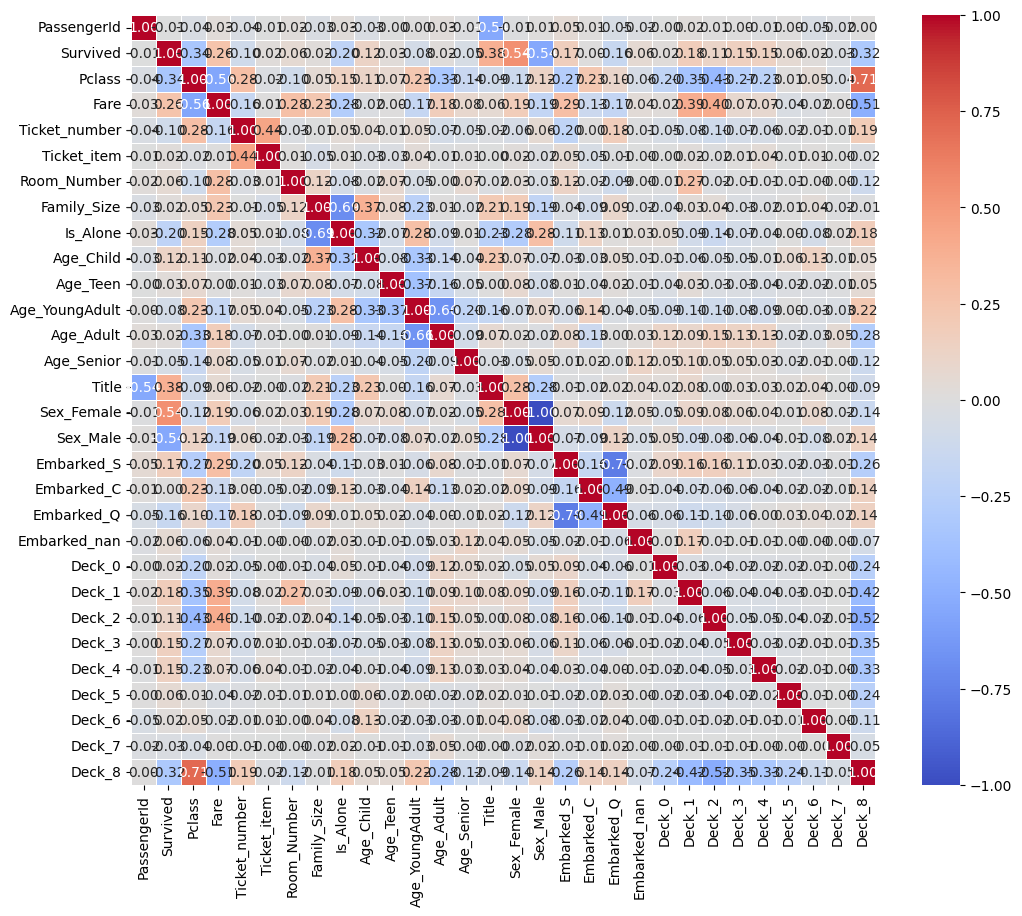

In [73]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

In [74]:
correlation_with_survived = data.corr()['Survived'].abs().sort_values(ascending=False)
threshold = 0.15
low_correlation_features = correlation_with_survived[correlation_with_survived < threshold].index
data.drop(low_correlation_features, axis=1, inplace=True)

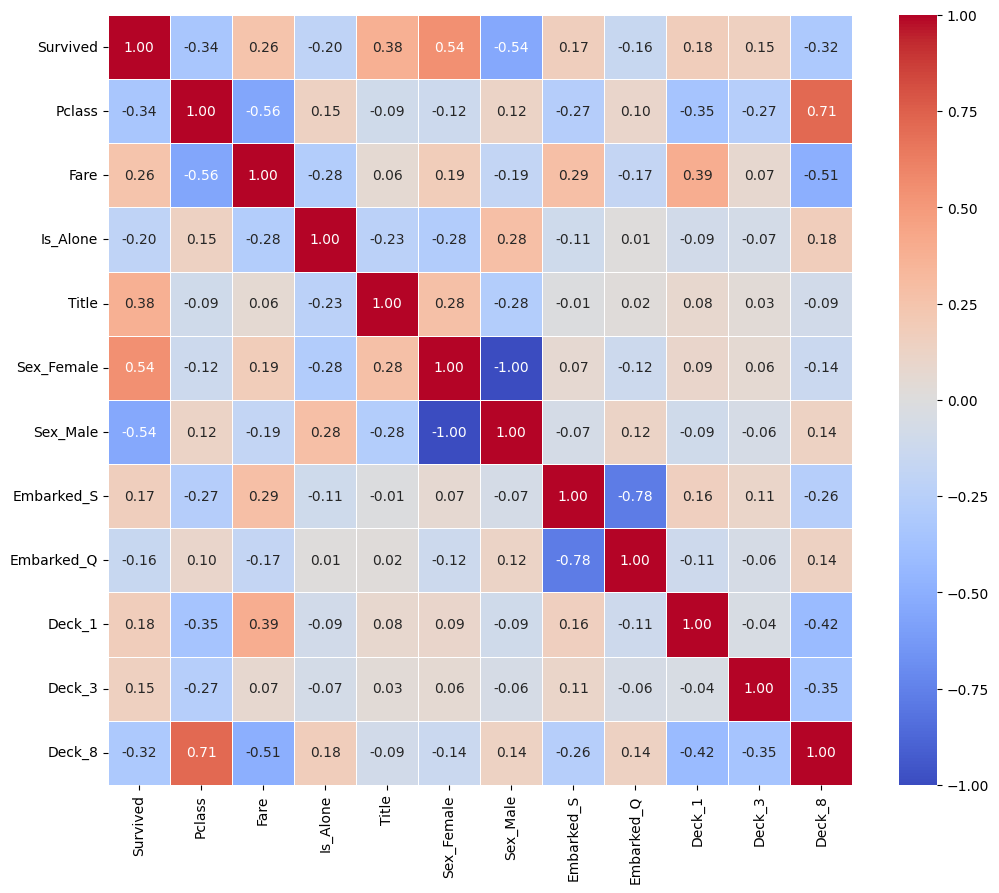

In [75]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

In [76]:
train_data = data.iloc[:len(train_data)]
test_data = data.iloc[len(train_data):]

In [77]:
X = train_data.drop('Survived', axis = 1)
X_predict= test_data.drop('Survived', axis = 1)

y = train_data['Survived']

outliers_mask = np.abs((X['Fare'] - X['Fare'].mean()) / X['Fare'].std()) > 3
print("Before replacement:")
print(X['Fare'].values[outliers_mask])
X_no_outliers = X.copy()
X_no_outliers.loc[outliers_mask, 'Fare'] = X['Fare'].mean()
print("After replacement:")
print(X_no_outliers['Fare'].values[outliers_mask])

Before replacement:
[263.     263.     247.5208 512.3292 247.5208 262.375  263.     211.5
 227.525  263.     221.7792 227.525  512.3292 211.3375 227.525  227.525
 211.3375 512.3292 262.375  211.3375]
After replacement:
[32.20420797 32.20420797 32.20420797 32.20420797 32.20420797 32.20420797
 32.20420797 32.20420797 32.20420797 32.20420797 32.20420797 32.20420797
 32.20420797 32.20420797 32.20420797 32.20420797 32.20420797 32.20420797
 32.20420797 32.20420797]


In [78]:
X_clean = X_no_outliers

param_grid = {
    'n_estimators': [50, 75, 100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10, 12, 15, 20, None],
    'min_samples_split': [2, 3, 5, 10, 12, 15, 17],
    'max_features': ['sqrt', 'log2', None]
}


rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_clean, y)
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

y_final_pred = best_rf_model.predict(X_predict)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits
Best Parameters: {'max_depth': 7, 'max_features': None, 'min_samples_split': 17, 'n_estimators': 200}
Best CV Score: 0.8316552633230808


In [79]:
score = cross_val_score(best_rf_model, X_clean, y, cv=5, scoring='accuracy').mean()
print(f"{score:.4f}")

0.8317


In [80]:
submission = pd.DataFrame()
submission['PassengerId'] = test_data_loading['PassengerId']
submission['Survived'] = y_final_pred
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('submission.csv', index = False)